In [2]:
import pandas as pd
import string
import unicodedata
import sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import sklearn.model_selection as cv
%matplotlib inline

In [3]:
data = pd.read_csv('text_emotion.csv')

In [4]:
smileyfaces = [':-)', ':)', ':D', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)']
sadfaces = ['>:[', ':-(', ':(', ':-c', ':c', ':-<', ':<', ':-[', ':[', ':{', '=(','=[', 'D:']
angryfaces = ['>:(', '(╯°□°)╯︵ ┻━┻']
cryingfaces = [":’-(", ":’("]
skepticalfaces = ['>:', '>:/', ':-/', '=/',':L', '=L', ':S', '>.<']
noexpressionfaces = [':|', ':-|', '(｀・ω・´)']
surprisedfaces = ['>:O', ':-O', ':O', ':-o', ':o', '8O', 'O_O', 'o-o', 'O_o', 'o_O', 'o_o', 'O-O']

In [5]:
def cleanText(wordSeries):
    def remove_punctuation(x):
        for char in string.punctuation:
            x = x.replace(char, ' ')
        return x
    for smile in smileyfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(smile, ' smileyface '))
    for sad in sadfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(sad,' sadface '))
    for angry in angryfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(angry, ' angryface '))
    for cry in cryingfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(cry, ' cryingface '))
    for skeptical in skepticalfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(skeptical, ' skepticalface '))
    for noexp in noexpressionfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(noexp, ' noexpressionfaces '))
    for surprised in surprisedfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(surprised, ' surprisedface '))
    wordSeries = wordSeries.apply(lambda x: x.replace('...', ' dotdotdot '))
    wordSeries = wordSeries.apply(lambda x: x.replace('!', ' exclamatory '))
    wordSeries = wordSeries.apply(lambda x: remove_punctuation(x))
    wordSeries = wordSeries.apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
    wordSeries = wordSeries.apply(lambda x: x.lower())
    #wordSeries = wordSeries.apply(lambda x: x.replace('http', ' '))
    wordSeries = wordSeries.apply(lambda x: ' '.join( [w for w in x.split() if len(w)>1] ))
    return wordSeries

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
def tokenize(documents):
    documents = cleanText(documents)
    docs = [word_tokenize(content) for content in documents]
    stopwords_=set(stopwords.words('english'))
    def filter_tokens(sent):
        return([w for w in sent if not w in stopwords_])
    docs=list(map(filter_tokens,docs))
    lemmatizer = WordNetLemmatizer()
    docs_lemma = [[lemmatizer.lemmatize(word) for word in words] for words in docs]
    return docs_lemma

In [7]:
def labelmood(mood):
    if mood in ['empty', 'sadness', 'worry', 'hate', 'boredom', 'anger']:
        return -1
    elif mood == 'neutral':
        return 0
    else:
        return 1

In [8]:
data['Tokens'] = tokenize(data['content'])
data['positive/negative'] = data['sentiment'].apply(lambda x: labelmood(x))

In [8]:
positive = data[data['positive/negative'] == 1]
negative = data[data['positive/negative'] == -1]
neutral = data[data['positive/negative'] == 0]

In [9]:
import operator
def createDict(token):
    words = {}
    for row in token:
        for word in row:
            if word in words:
                words[word] += 1
            else:
                words[word] = 1
    sorted_d = dict( sorted(words.items(), key=operator.itemgetter(1),reverse=True))
    return sorted_d

In [10]:
positivewords = createDict(positive['Tokens'])
negativewords = createDict(negative['Tokens'])
neutralwords = createDict(neutral['Tokens'])
words = createDict(data['Tokens'])

In [11]:
keys = [k for k in words]
vals = [v for v in words.values()]
keys_p = [k for k in positivewords]
vals_p = [v for v in positivewords.values()]
keys_n = [k for k in negativewords]
vals_n = [v for v in negativewords.values()]
keys_neutral = [k for k in neutralwords]
vals_neutral = [v for v in neutralwords.values()]

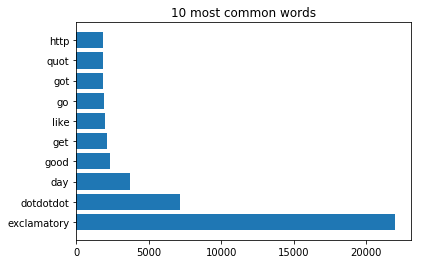

In [12]:
import matplotlib.pyplot as plt

plt.barh(keys[:10], vals[:10], align='center')
plt.title("10 most common words")
plt.show()

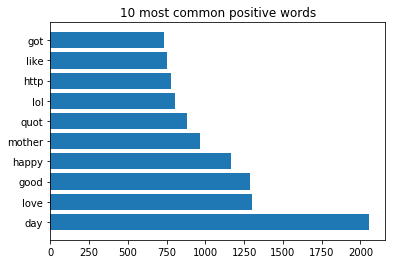

In [13]:
plt.barh(keys_p[2:12], vals_p[2:12], align='center')
plt.title("10 most common positive words")
plt.show()

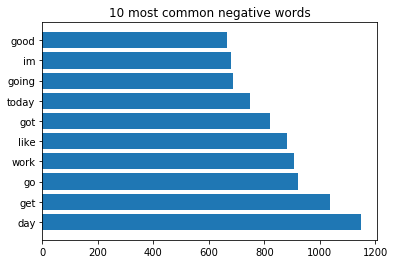

In [14]:
plt.barh(keys_n[2:12], vals_n[2:12], align='center')
plt.title("10 most common negative words")
plt.show()

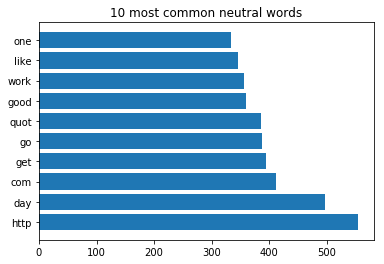

In [15]:
plt.barh(keys_neutral[2:12], vals_neutral[2:12], align='center')
plt.title("10 most common neutral words")
plt.show()

In [9]:
data['tokenJ'] = data['Tokens'].apply(lambda x: ' '.join(x))
corpus = [row for row in data['tokenJ']]

In [10]:
tf = CountVectorizer()

document_tf_matrix = tf.fit_transform(corpus).todense()

tfidf = TfidfVectorizer()
document_tfidf_matrix = tfidf.fit_transform(corpus)

In [11]:
X = document_tfidf_matrix
y = data['sentiment']

In [12]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25)

In [20]:
lg = LogisticRegression()
lg.fit(Xtrain,ytrain)

/Users/brooks/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
def getTopN(n, reg, X, y):
    probs = reg.predict_proba(X)
    topN = []
    for prob in probs:
        best_N = list(reversed(np.argsort(prob)))[:n]
        topN.append(best_N)
    topN = np.array(topN)
    mood = np.array(sorted(y.unique()))
    topNpred = mood[topN]
    return topNpred

In [22]:
def getScore(X, y):
    count = 0
    for idx in range(len(y)):
        if np.array(y)[idx] in X[idx]:
            count+=1
    return count/len(y)

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

In [86]:
model = GradientBoostingClassifier()

In [87]:
model.fit(Xtrain, ytrain)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [89]:
model.score(Xtest, ytest)

0.3229

In [90]:
top3 = getTopN(3, model, Xtest, ytest)

In [91]:
getScore(top3, ytest)

0.6552

In [93]:
from xgboost import XGBClassifier

In [98]:
xg = XGBClassifier(random_state=1,learning_rate=0.01, n_estimators = 300)

In [99]:
xg.fit(Xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=1, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [100]:
xg.score(Xtest, ytest)

0.307

In [101]:
top3 = getTopN(3, xg, Xtest, ytest)
getScore(top3, ytest)

0.6482

In [23]:
from sklearn.experimental import enable_hist_gradient_boosting

In [24]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [1]:
X

NameError: name 'X' is not defined

In [ ]:
grad = HistGradientBoostingClassifier()
grad.fit(Xtrain.toarray(), ytrain)

In [17]:
N_ESTIMATORS = 100
N_FOLDS = 5

learning_rates = [0.2, 0.1, 0.025, 0.01]
N_LEARNING_RATES = len(learning_rates)

train_scores = np.zeros((N_FOLDS, N_LEARNING_RATES, N_ESTIMATORS))
test_scores = np.zeros((N_FOLDS, N_LEARNING_RATES, N_ESTIMATORS))

folds = cv.KFold(n_splits=N_FOLDS, shuffle=True, random_state=1)

for k, (train_idxs, test_idxs) in enumerate(folds.split(X)):
    X_train, y_train = X[train_idxs, :], y[train_idxs]
    X_test, y_test = X[test_idxs, :], y[test_idxs]

    models = [GradientBoostingClassifier(n_estimators = N_ESTIMATORS,
                                        max_depth=3, learning_rate=lr, subsample=0.5,
                                        random_state=154) 
              for lr in learning_rates]
    for model in models:
        model.fit(X_train, y_train)
    
    for i, model in enumerate(models):
        for j, y_pred in enumerate(model.staged_predict(X_train)):
            train_scores[k, i, j] = model.loss_(y_train, y_pred)
        
    for i, model in enumerate(models):
        for j, y_pred in enumerate(model.staged_predict(X_test)):
            test_scores[k, i, j] = model.loss_(y_test, y_pred)

mean_train_scores = np.mean(train_scores, axis=0)
mean_test_scores = np.mean(test_scores, axis=0)

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, 
                         figsize=(18.0, 8.0))
 
for i, rate in enumerate(learning_rates):    
    ## train scores
    axes[0].plot(np.arange(N_ESTIMATORS) + 1, mean_train_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Learning Rate = " + str(rate))
    ## test scores
    axes[1].plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Learning Rate = " + str(rate))
## common format
for ax in axes:
    ax.legend(loc = "upper right")
    ax.set_xlabel('Number of Boosting Stages', fontsize=14)
    ax.set_ylabel('Average Squared Error', fontsize=14)
## subplot titles
axes[0].set_title("Effect of Varying the Learning Rate on Training Error")
axes[1].set_title("Testing Data")

plt.ylim([0, 20])
_ = plt.suptitle("Effect of Varying the Learning Rate", fontsize=20)
# plt.savefig('plots/varying-learning-rate-error.png', bbox_inches='tight')